# Roadmap

The goal of this notebook is to provide an example of how to scrape NEXRAD level II data and use pyart and csu_radar_tools to calculate radar rainfall estimates at rain gage locations during a storm. Inspiration from the discussion [here](https://groups.google.com/forum/#!msg/pyart-users/dxw0Mm7-SzI/iRI3-yXxDQAJ)

  1. Genarate mock rain gage data
  2. Download available NEXRAD data
  5. Download sounding data
  6. Classify hydrometeors
  7. Compute rainfall estimate
  8. Interpolate radially
  9. Pull out rainfall estimates at gage locations

Before getting started, set up your environment with all the necessities to run this notebook. To create this environment just run **`$ conda env create -f environment.yml`** where **`environment.yml`** is a file containing the following:

In [ ]:
!cat environment.yml

## Mock rain gage data

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr

In [3]:
ID='KTLH'
latitude = 30.39758301
longitude = -84.32894135

year=2016
month=9
day=2
hour=2

t_start = '2016-09-02 02:00'
t_end = '2016-09-02 04:00'

In [4]:
%%time

netcdf=True

gage_times = pd.date_range(pd.datetime(year, month, day, hour), freq='15min', periods=10, tz='UTC')
gage_locs = np.random.rand(50,2)*2+ np.array([latitude, longitude])
gage_data = np.zeros((gage_times.shape[0], gage_locs.shape[0]))
gage_names = ['G'+str(i) for i in range(1, gage_locs.shape[0]+1)]

gage_df_data = pd.DataFrame(index=gage_times, data=gage_data, columns=gage_names)
gage_df_locs = pd.DataFrame(index=gage_names, data=gage_locs, columns=['lat', 'lon'])

if not netcdf:
    gage_df = pd.concat([gage_df_locs, gage_df_data.T], axis=1)
    gage_df.head()

def to_da(i, name, gage_data, gage_times):
    return xr.DataArray(gage_data[:,i], name=name, dims={'time': gage_times.shape},
                        coords={'time': gage_times.astype('datetime64[ns]'), 'station':name})

datasets = [to_da(i, name, gage_data, gage_times) for i, name in enumerate(gage_names)]
combined = xr.concat(datasets, 'station')
ds0 = combined.to_dataset(name='rain_gage_accumulation')

gage_df_locs.index.name='station'
ds_gage = ds0.merge(xr.Dataset(gage_df_locs))
ds_gage.set_coords(['lat', 'lon'], inplace=True)
print(ds_gage)

<xarray.Dataset>
Dimensions:                 (station: 50, time: 10)
Coordinates:
  * time                    (time) datetime64[ns] 2016-09-02T02:00:00 ...
  * station                 (station) |S3 'G1' 'G2' 'G3' 'G4' 'G5' 'G6' 'G7' ...
    lat                     (station) float64 31.92 31.8 31.48 32.22 31.78 ...
    lon                     (station) float64 -82.84 -82.73 -83.31 -83.19 ...
Data variables:
    rain_gage_accumulation  (station, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
CPU times: user 23.9 ms, sys: 696 µs, total: 24.6 ms
Wall time: 44.8 ms


## Download available data

In [5]:
import xarray as xr
import pyart

from pyart_radar_tools import *

In [6]:
paths = data_download(ID, t_start, t_end)

using cached file ...
./tmp/KTLH20160902_015528_V06
using cached file ...
./tmp/KTLH20160902_020138_V06
using cached file ...
./tmp/KTLH20160902_020748_V06
using cached file ...
./tmp/KTLH20160902_021359_V06
using cached file ...
./tmp/KTLH20160902_022009_V06
using cached file ...
./tmp/KTLH20160902_022617_V06
using cached file ...
./tmp/KTLH20160902_023228_V06
using cached file ...
./tmp/KTLH20160902_023838_V06
using cached file ...
./tmp/KTLH20160902_024448_V06
using cached file ...
./tmp/KTLH20160902_025125_V06
using cached file ...
./tmp/KTLH20160902_025803_V06
using cached file ...
./tmp/KTLH20160902_030439_V06
using cached file ...
./tmp/KTLH20160902_031116_V06
using cached file ...
./tmp/KTLH20160902_031754_V06
using cached file ...
./tmp/KTLH20160902_032431_V06
using cached file ...
./tmp/KTLH20160902_033108_V06
using cached file ...
./tmp/KTLH20160902_033746_V06
using cached file ...
./tmp/KTLH20160902_034426_V06
using cached file ...
./tmp/KTLH20160902_035104_V06


## Sounding

Optionally you can get data from a nearby sounding in the UWyo format (i.e., from http://weather.uwyo.edu/upperair/sounding.html), and copy and paste it into a txt file. 

In [7]:
from skewt import SkewT
sounding = SkewT.Sounding('./tmp/sounding.txt')

In [8]:
fields = ['rain', 'r_kdp', 'r_z']

## Run
First we need to import the tools from pyart_radar_tools, then we can process all the radar files

In [9]:
def process_radar(path, sounding, run_QAQC=True,
                  min_dist_km=5, max_dist_km=250,
                  sw_vel=True, max_time_diff=30):
    radar = pyart.io.read(path)
    radar = extract_low_sweeps(radar)

    # run some QAQC:
    if run_QAQC:
        start_gate = get_gate_index(radar, dist_km=min_dist_km)
        end_gate = get_gate_index(radar, dist_km=max_dist_km)
        QAQC_mask = construct_QAQC_mask(radar, start_gate, end_gate,
                                        sw_vel=sw_vel,
                                        max_time_diff=max_time_diff)

    # get out just the sweeps with differential phase values
    radar = extract_field_sweeps(radar, field='differential_phase')

    # do computations
    radar = calculate_hidro_rain(radar, sounding)
    radar = calculate_rain_nexrad(radar)
    radar = calculate_rain_kdp(radar)
    if run_QAQC:
        for field in ['rain', 'r_kdp', 'r_z']:
            radar = interpolate_radially(radar, field, QAQC_mask,
                                         start_gate, end_gate)
    return radar

In [10]:
%%time
radar0 = pyart.io.read(paths[0])
netcdf=True
gage_dict={}
for gage_name in gage_names:
    if netcdf:
        latitude = ds_gage.lat.sel(station=gage_name).values
        longitude = ds_gage.lon.sel(station=gage_name).values
    else:
        latitude = gage_df.loc[gage_name, 'lat']
        longitude = gage_df.loc[gage_name, 'lon']
    x_disp, y_disp = find_x_y_displacement(radar0, longitude, latitude)
    gage_dict.update({gage_name: {'x_disp': x_disp, 'y_disp': y_disp}})

sweep_times = []
sweep_stacks = []
for path in paths:
    print('processing', path)
    radar = process_radar(path, sounding)

    for sweep in range(radar.nsweeps):
        # get time
        end_sweep_time = get_end_sweep_time(radar, sweep)
        sweep_times.append(end_sweep_time)
        
        # get data at point
        sweep_stack = retrieve_points(radar, sweep, fields, gage_dict)
        sweep_stacks.append(sweep_stack)
c = np.stack(sweep_stacks, axis=2)

cols = ['gate_lon', 'gate_lat', 'gate_altitude']
cols.extend(fields)
d = {'time': {'dims': ('time'), 'data': sweep_times},
     'station': {'dims': ('station'), 'data': gage_names}}
for i, name in enumerate(cols):
    d.update({name: {'dims': ('station', 'time'), 'data': c[i]}})
ds_radar = xr.Dataset.from_dict(d)
ds_radar.set_coords(['gate_altitude', 'gate_lat', 'gate_lon'], inplace=True)

('processing', './tmp/KTLH20160902_015528_V06')


/home/jsignell/miniconda2/envs/radar/lib/python2.7/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


('processing', './tmp/KTLH20160902_020138_V06')
('processing', './tmp/KTLH20160902_020748_V06')
('processing', './tmp/KTLH20160902_021359_V06')
('processing', './tmp/KTLH20160902_022009_V06')
('processing', './tmp/KTLH20160902_022617_V06')
('processing', './tmp/KTLH20160902_023228_V06')
('processing', './tmp/KTLH20160902_023838_V06')
('processing', './tmp/KTLH20160902_024448_V06')
('processing', './tmp/KTLH20160902_025125_V06')
('processing', './tmp/KTLH20160902_025803_V06')
('processing', './tmp/KTLH20160902_030439_V06')
('processing', './tmp/KTLH20160902_031116_V06')
('processing', './tmp/KTLH20160902_031754_V06')
('processing', './tmp/KTLH20160902_032431_V06')
('processing', './tmp/KTLH20160902_033108_V06')
('processing', './tmp/KTLH20160902_033746_V06')
('processing', './tmp/KTLH20160902_034426_V06')
('processing', './tmp/KTLH20160902_035104_V06')
CPU times: user 10min 23s, sys: 7.99 s, total: 10min 31s
Wall time: 10min 40s


In [11]:
%%time
ds_radar_15 = ds_radar[fields].resample('15min', 'time', label='right')

CPU times: user 20.3 ms, sys: 31 µs, total: 20.3 ms
Wall time: 57.1 ms


In [12]:
%%time
ds = ds_gage.merge(ds_radar_15)

CPU times: user 1.77 ms, sys: 0 ns, total: 1.77 ms
Wall time: 1.56 ms


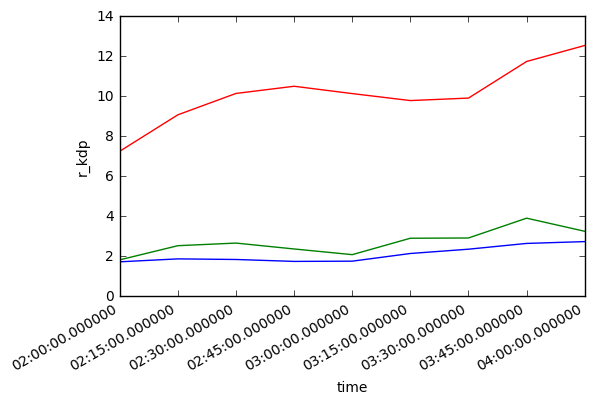

In [13]:
%matplotlib inline
ds.rain.mean('station').plot(c='g')
ds.r_z.mean('station').plot(c='b')
ds.r_kdp.mean('station').plot(c='r')